# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Изучение данных из файла

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from matplotlib.ticker import ScalarFormatter

In [45]:
df = pd.read_csv('/datasets/real_estate_data.csv','\t')
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,...,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,...,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,...,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,...,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,...,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


Посмотрим на процент пропусков по столбцам:

In [46]:
pd.DataFrame(round((df.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,38.800000
floors_total,0.360000
living_area,8.030000
floor,0.000000
is_apartment,88.290000


**Вывод:**
В некоторых столбцах достаточно много пропусков, придется от них избавляться.

## Предобработка данных

In [47]:
df['last_price'] = df['last_price'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  int64  
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Задали тип данных int64

In [48]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'] ,  format='%Y%m%dT')
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108.0,2019-03-07,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000,40.4,2018-12-04,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000,56.0,2015-08-20,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000,159.0,2015-07-24,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000,100.0,2018-06-19,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Мы отформатировали столбец с датой в соответствии со стандартами, теперь из этого столбца можно выделять интересующие нас данные: день, месяц, год.

In [49]:
celing_height_median = df['ceiling_height'].median()
df.loc[df["ceiling_height"] >= 4, "ceiling_height"] = df.loc[df["ceiling_height"] <=4, "ceiling_height"].median()
df['ceiling_height'] = df['ceiling_height'].fillna(celing_height_median)
df.loc[df['ceiling_height'] <=2.5,'ceiling_height'] = df.loc[df['ceiling_height'] >=2.5, 'ceiling_height'].median()

Здесь мы изменили аномальную, по моему мнению, высоту потолков (выше 4х метров и меньше 2.5) на медианное значение по всему датасету.

In [50]:
floors_total_median = df['floors_total'].median()
df['floors_total'] = df['floors_total'].fillna(floors_total_median)
df['floors_total'] = df['floors_total'].astype(int)

Заменили пропущенные значения в столбце "общее количество этажей", пропущенных значений, кстати, весьма мало.

In [51]:
living_area_median = df['living_area'].median()
df['living_area'] = df['living_area'].fillna(living_area_median)

Заменили пропущенные значения в столбце "жилая площадь"

In [52]:
df['is_apartment'] = df['is_apartment'].fillna(False)
df['is_apartment'] = df['is_apartment'].astype(bool)
df['is_apartment'].unique()

array([False,  True])

Заменили пропущенные значение на False в столбце "аппартаменты", задаем тип данных bool

In [53]:
df['kitchen_area'].fillna(0, inplace=True)
len(df['kitchen_area'])

23699

Мы задали значение 0 в пропущенных строках в столбце "площадь кухни".

In [54]:
df['balcony'].fillna(0,  inplace=True) #заменяем NaN на значение 0 балконов в квартире
df['balcony'] = df['balcony'].astype(int) #меняем тип данных на целочисленное int
df['balcony'].drop_duplicates().reset_index() #проверяем результат

,index,balcony
0,0,0
1,1,2
2,6,1
3,41,5
4,121,4
5,524,3


Заполним пропуски в столбцах, используюя медиану:

In [55]:
airports_nearest_median = df['airports_nearest'].median()
df['airports_nearest'] = df['airports_nearest'].fillna(airports_nearest_median)
df['airports_nearest'] = df['airports_nearest'].astype(int)

In [56]:
df.columns = df.columns.str.lower()
citycenters_nearest_median = df['citycenters_nearest'].median()
df['citycenters_nearest'] = df['citycenters_nearest'].fillna(citycenters_nearest_median)
df['citycenters_nearest'] = df['citycenters_nearest'].astype(int)

In [57]:
parks_around3000_median = df['parks_around3000'].median()
df['parks_around3000'] = df['parks_around3000'].fillna(parks_around3000_median)
df['parks_around3000'] = df['parks_around3000'].astype(int)

In [58]:
parks_nearest_median = df['parks_nearest'].median()
df['parks_nearest'] = df['parks_nearest'].fillna(parks_nearest_median)
df['parks_nearest'] = df['parks_nearest'].astype(int)

In [59]:
ponds_around3000_median = df['ponds_around3000'].median()
df['ponds_around3000'] = df['ponds_around3000'].fillna(ponds_around3000_median)
df['ponds_around3000'] = df['ponds_around3000'].astype(int)

In [60]:
ponds_nearest_median = df['ponds_nearest'].median()
df['ponds_nearest'] = df['ponds_nearest'].fillna(ponds_nearest_median)
df['ponds_nearest'] = df['ponds_nearest'].astype(int)

In [61]:
days_exposition_median = df['days_exposition'].median()
df['days_exposition'] = df['days_exposition'].fillna(days_exposition_median)
df['days_exposition'] = df['days_exposition'].astype(int)

In [62]:
df['locality_name']  = df['locality_name'].astype(str)
df['locality_name']  = df['locality_name'].str.lower()
df['locality_name']  = df['locality_name'].str.replace('ё','е')
df['locality_name'].unique()

array(['санкт-петербург', 'поселок шушары', 'городской поселок янино-1',
       'поселок парголово', 'поселок мурино', 'ломоносов', 'сертолово',
       'петергоф', 'пушкин', 'деревня кудрово', 'коммунар', 'колпино',
       'поселок городского типа красный бор', 'гатчина',
       'деревня федоровское', 'выборг', 'кронштадт', 'кировск',
       'деревня новое девяткино', 'поселок металлострой',
       'поселок городского типа лебяжье',
       'поселок городского типа сиверский', 'поселок молодцово',
       'поселок городского типа кузьмоловский',
       'садовое товарищество новая ропша', 'павловск',
       'деревня пикколово', 'всеволожск', 'волхов', 'кингисепп',
       'приозерск', 'сестрорецк', 'деревня куттузи', 'поселок аннино',
       'поселок городского типа ефимовский', 'поселок плодовое',
       'деревня заклинье', 'поселок торковичи', 'поселок первомайское',
       'красное село', 'поселок понтонный', 'сясьстрой', 'деревня старая',
       'деревня лесколово', 'поселок новый свет

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  int64         
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  int64         
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

**Вывод:**  
Выше мы нашли медиану для целого ряда столбцов и заменили на нее пропущенные значения, а так же присвоили новый тип данных: int64, а так же отредактировали столбец 'населенный пункт'.

## Расчёты и добавление результатов в таблицу

In [64]:
df['price_m2'] = df['last_price'] / df['total_area'] #добавили столбец с ценой за кв.м. жилплощади
df['price_m2'] = df['price_m2'].astype(int) #привели к целочисленному значению
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,citycenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_m2
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,0,санкт-петербург,18863,16028,1,482,2,755,95,120370
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,2,поселок шушары,12817,18603,0,455,0,502,81,82920
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,0,санкт-петербург,21741,13933,1,90,2,574,558,92785
3,0,64900000,159.0,2015-07-24,3,2.65,14,30.0,9,False,...,0,санкт-петербург,28098,6800,2,84,3,234,424,408176
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,0,санкт-петербург,31856,8098,2,112,1,48,121,100000


Здесь мы нашли стоимость кв.м. квартиры, данные поместили в новый столбец.

In [67]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'])
df['day_of_week'] = df['first_day_exposition'].dt.weekday
df['month'] = df['first_day_exposition'].dt.month
df['year'] = df['first_day_exposition'].dt.year
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,citycenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_m2,day_of_week,month,year
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,16028,1,482,2,755,95,120370,3,3,2019
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,18603,0,455,0,502,81,82920,1,12,2018
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,13933,1,90,2,574,558,92785,3,8,2015
3,0,64900000,159.0,2015-07-24,3,2.65,14,30.0,9,False,...,6800,2,84,3,234,424,408176,4,7,2015
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,8098,2,112,1,48,121,100000,1,6,2018


Из столбца с датой выделили в новые столбцы день недели, месяц и год, соответственно.

In [68]:
def floor_group(row):
    floor = row['floor']
    floors_total = row['floors_total']

    if floor == 1:
        return 'первый'

    if floor == floors_total:
        return 'последний'
    return 'другой'
df['floor_type'] = df.apply(floor_group, axis=1) #применяем функцию по определнию типа этажа и создаем новый столбец floors_type
df.floor_type.value_counts()

другой       17441
последний     3341
первый        2917
Name: floor_type, dtype: int64

Применили функцию и создали новый столбец, где значением выступает тип этажа (первый, последний, другой).

In [69]:
df['area_ratio1'] = df['living_area'] / df['total_area'] 
df.head() 

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_m2,day_of_week,month,year,floor_type,area_ratio1
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,482,2,755,95,120370,3,3,2019,другой,0.472222
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,455,0,502,81,82920,1,12,2018,первый,0.460396
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,90,2,574,558,92785,3,8,2015,другой,0.612500
3,0,64900000,159.0,2015-07-24,3,2.65,14,30.0,9,False,...,84,3,234,424,408176,4,7,2015,другой,0.188679
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,112,1,48,121,100000,1,6,2018,другой,0.320000


Создали новый столбец area_ratio1, который показывает соотношение жилой площади помещения и общей.


In [70]:
df['area_ratio2'] = df['kitchen_area'] / df['total_area']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  int64         
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  int64         
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

Создали новый столбец area_ratio2, который показывает соотношение площади кухни и общей площади квартиры.

In [71]:
df['citycenters_nearest_km'] = df['citycenters_nearest'] / 1000
df['citycenters_nearest_km'] = df['citycenters_nearest_km'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            23699 non-null  int64         
 1   last_price              23699 non-null  int64         
 2   total_area              23699 non-null  float64       
 3   first_day_exposition    23699 non-null  datetime64[ns]
 4   rooms                   23699 non-null  int64         
 5   ceiling_height          23699 non-null  float64       
 6   floors_total            23699 non-null  int64         
 7   living_area             23699 non-null  float64       
 8   floor                   23699 non-null  int64         
 9   is_apartment            23699 non-null  bool          
 10  studio                  23699 non-null  bool          
 11  open_plan               23699 non-null  bool          
 12  kitchen_area            23699 non-null  float6

Создали новый столбец, который показывает удаленность от центра в километрах.

## Исследовательский анализ данных

Для нашего исследования важны следующие ключевые переменные:  

**Площадь** ('total_area')  
**Цена** ('last_price')  
**Число комнат** ('rooms')  
**Высота потолков** ('ceiling_height')  
**Время продажи квартиры** ('days_exposition')  

Подробно изучим их и отфильтруем, убрав аномальные значения, для изучения будем использовать методы **scribe(), hist() и boxplot()**, для среза данных метод **query().**


In [72]:
df['total_area'].describe()

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

Построим гистограмму для признака total_area:

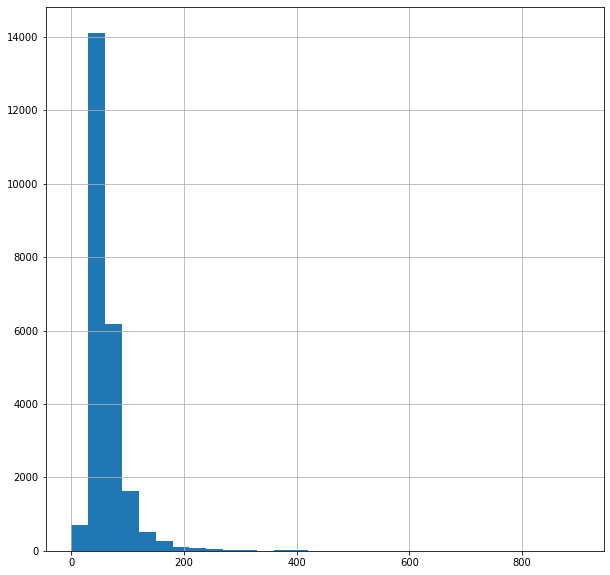

In [73]:
df['total_area'].hist(bins=30, figsize=(10,10), range=(0,900));

Здесь мы видим, что основная часть приходится на квартиры до 70 кв.м

(-100.0, 300.0)

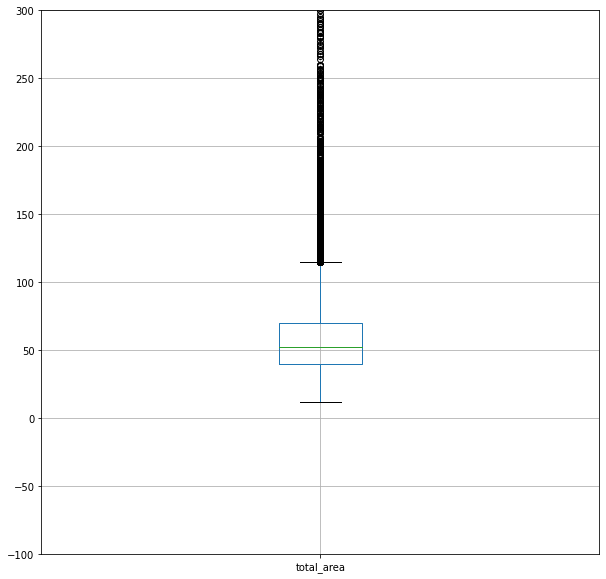

In [74]:
df.boxplot(column='total_area', figsize=(10,10))
plt.ylim(-100, 300)


In [75]:
df['rooms'].describe()

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

Построим гистограмму для признака rooms:

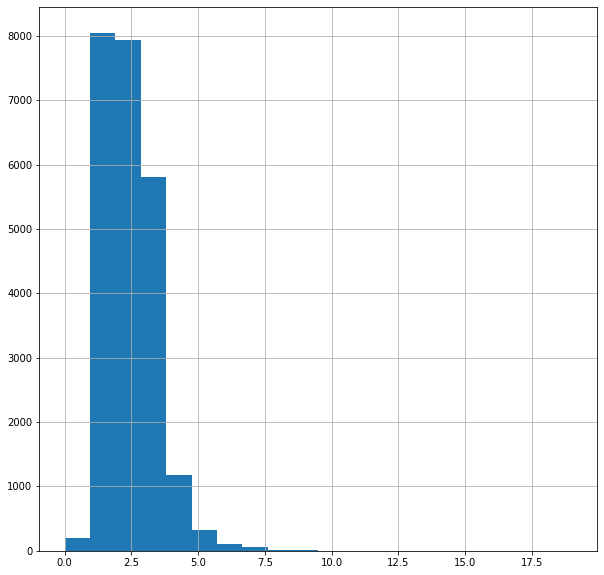

In [76]:
df['rooms'].hist(bins=20, figsize=(10,10));

Основная часть приходится на 1-2 комнатные квартиры.

(-1.0, 25.0)

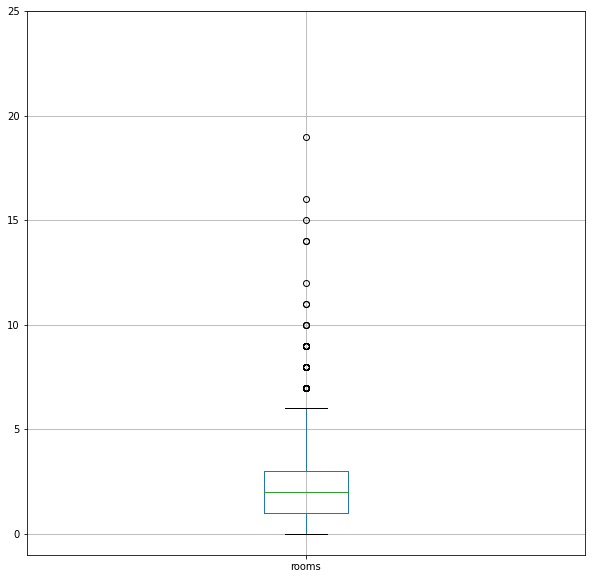

In [77]:
df.boxplot(column='rooms', figsize=(10,10))
plt.ylim(-1, 25)

In [78]:
df['last_price'].describe()

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

Построим гистограмму для признака last_price:

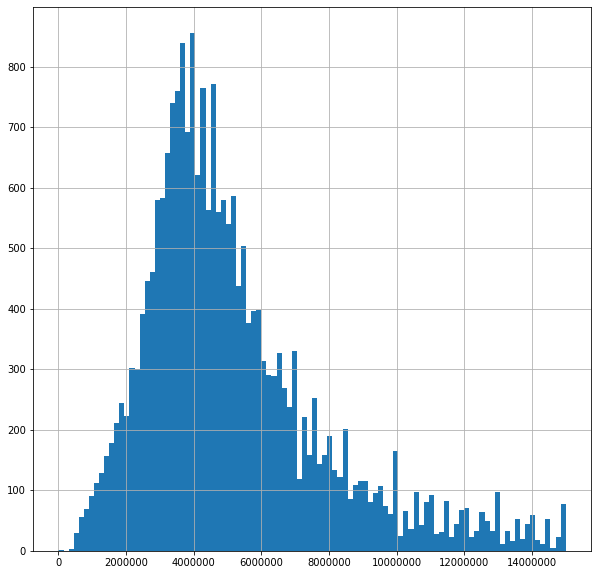

In [79]:
df['last_price'].hist(bins=100, figsize=(10,10), range=(0,15000000))
plt.ticklabel_format(style='plain')
plt.show()

Касаемо цены: медианное значение около 5 млн. рублей.

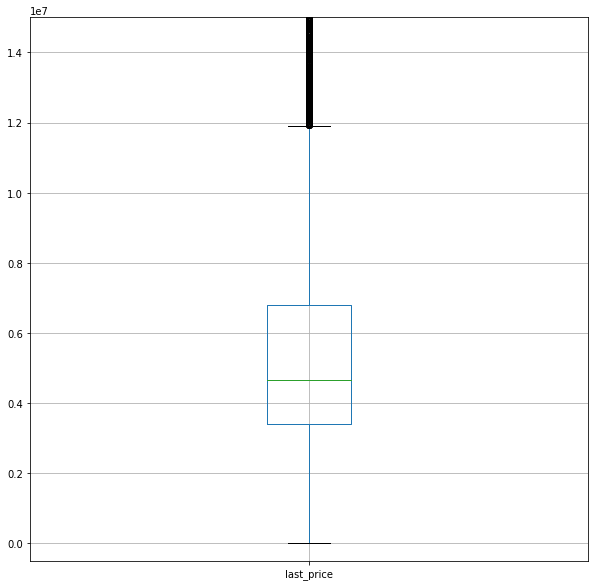

In [80]:
df.boxplot(column='last_price', figsize=(10,10))
plt.ylim(-500000,15000000)
plt.show()


In [81]:
df['ceiling_height'].describe()

count    23699.000000
mean         2.714128
std          0.181212
min          2.510000
25%          2.650000
50%          2.650000
75%          2.700000
max          3.980000
Name: ceiling_height, dtype: float64

Построим гистограмму для признака ceiling_height:

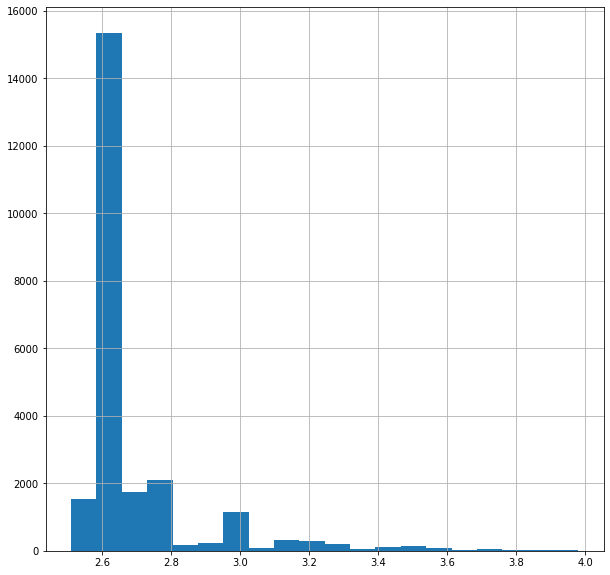

In [82]:
df['ceiling_height'].hist(bins=20, figsize=(10,10));

Потолки в квартирах в основном не выше 2.7м

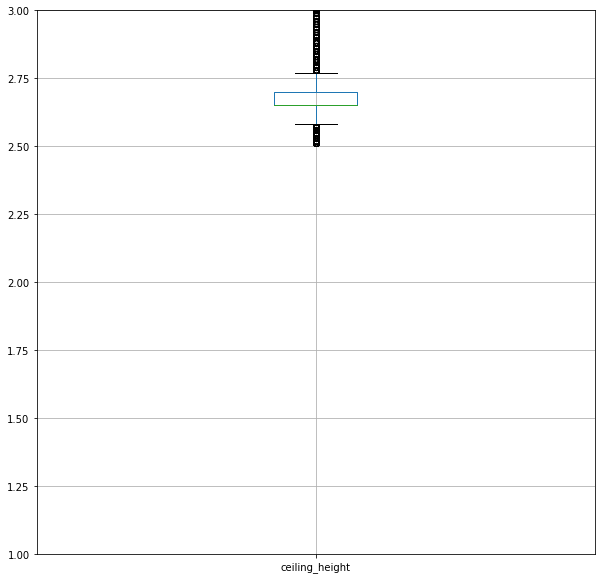

In [83]:
df.boxplot(column='ceiling_height', figsize=(10,10))
plt.ylim(1,3)
plt.show()

In [84]:
df['days_exposition'].describe()

count    23699.000000
mean       169.360226
std        206.535633
min          1.000000
25%         45.000000
50%         95.000000
75%        199.000000
max       1580.000000
Name: days_exposition, dtype: float64

Построим гистограмму для признака days_exposition:

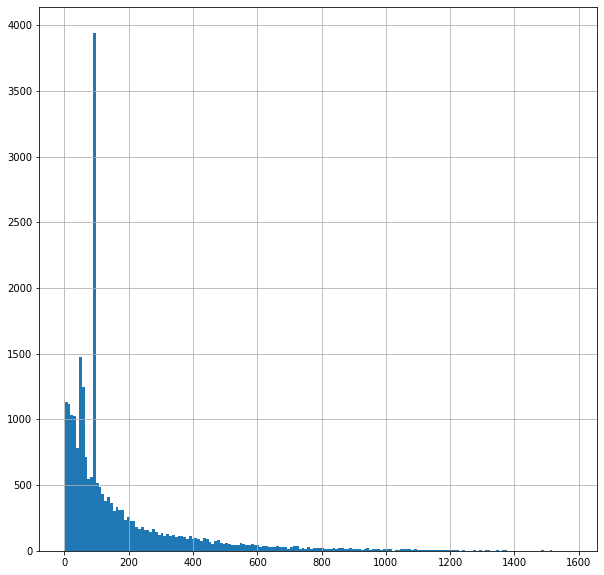

In [85]:
df['days_exposition'].hist(bins=180, figsize=(10,10));


На основании гистограммы можно сделать вывод, что основное количество продаж происходит в первые 200 дней после размещения, в этом диапазоне явно выделяется значение около 100 дней - количество продаж почти 4000.

<AxesSubplot:>

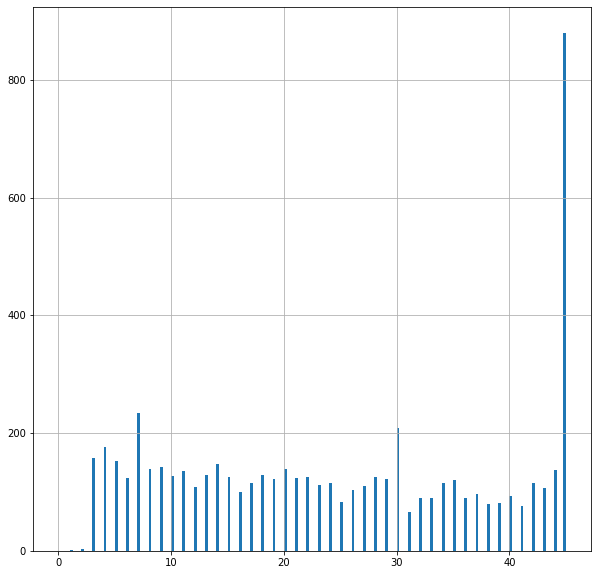

In [86]:
df['days_exposition'].hist(bins=180, figsize=(10,10), range=(0, 45))

(0.0, 1000.0)

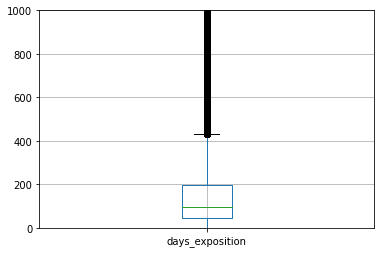

In [87]:
df.boxplot(column='days_exposition')
plt.ylim(0, 1000)


(-50.0, 600.0)

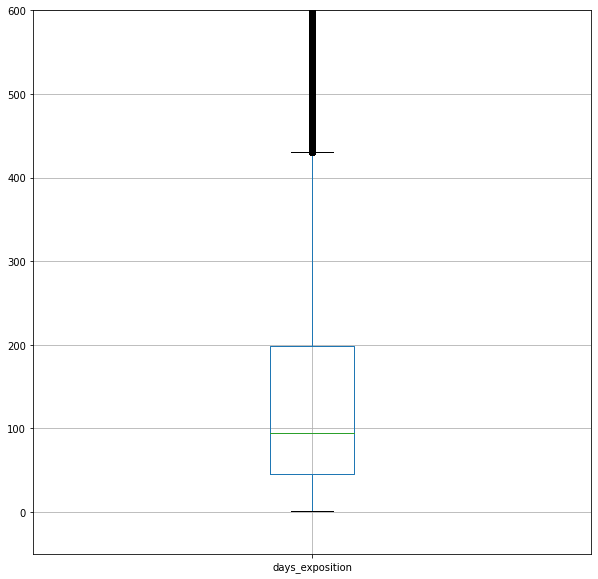

In [88]:
df.boxplot(column='days_exposition', figsize=(10,10))
plt.ylim(-50, 600)

**Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?**   

Значения, которые меньше Q1 (< 45 дней) говорят о том, что продажа квартиры прошла достаточно быстро.  
Значения, которые больше Q3 (> 199 дней) говорят о том, что продажа квартиры затянулась.

Далее создадим срез по всем ключевым метрикам, откинув аномальные значения за границами значений ящика с усами.

**Площадь** (total_area)  
**Цена** (1ast_price)  
**Число комнат** (rooms)  
**Высота потолков** (ceiling_height) - в дальнейшем решил не делать срез по этой метрике, т.к. значения до 4 метров выглядят весьма реалистичными и исключать их из датафрейма не хочется.  
**Время продажи квартиры** (days_exposition) - так же не делаем срез по этой метрике.  

In [89]:
Q1_ta = df.total_area.quantile(0.25) # 1квантиль по столбцу общая площадь, далее по аналогии для каждого столбца
Q3_ta = df.total_area.quantile(0.75) # 3квантиль по столбцу общая площадь, далее по аналогии для каждого столбца
IQR = Q3_ta - Q1_ta
Q1_lp = df.last_price.quantile(0.25)
Q3_lp = df.last_price.quantile(0.75)
IQR2 = Q3_lp-Q1_lp
Q1_r = df.rooms.quantile(0.25)
Q3_r= df.rooms.quantile(0.75)
IQR3 = Q3_r - Q1_r
#Q1_ch = df.ceiling_height.quantile(0.25)
#Q3_ch = df.ceiling_height.quantile(0.75)
#IQR4 = Q3_ch - Q1_ch
Q1_de = df.days_exposition.quantile(0.25)
Q3_de = df.days_exposition.quantile(0.75)
IQR5 = Q3_de - Q1_de
good_data = df.query('((@Q1_ta - 1.5 * @IQR) <= total_area <= (@Q3_ta + 1.5 * @IQR)) \
    & ((@Q1_lp - 1.5 * @IQR2) <= last_price <= (@Q3_lp + 1.5 * @IQR2)) \
    & ((@Q1_r - 1.5 * @IQR3) <= rooms <= (@Q3_r + 1.5 * @IQR3))')
good_data.last_price.describe()

count    2.148200e+04
mean     4.810619e+06
std      2.191515e+06
min      1.219000e+04
25%      3.300000e+06
50%      4.400000e+06
75%      5.967300e+06
max      1.190000e+07
Name: last_price, dtype: float64

In [90]:
(len(df)- len(good_data))/ len(df)* 100 # мы отсеяли из датафрейма 9.35 % датафрейма, многовато.

9.354825098105406

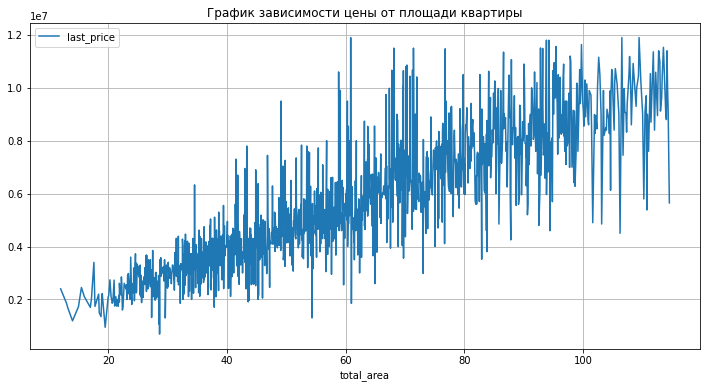

In [91]:
(
good_data
    .pivot_table(index='total_area', values='last_price', aggfunc='median') 
    .plot(title='График зависимости цены от площади квартиры', grid=True, figsize=(12, 6))
    
);

In [92]:
good_data['total_area'].corr(good_data['last_price'])

0.695302142067236

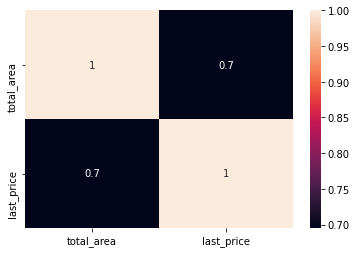

In [93]:
corr_data = good_data[['total_area', 'last_price']]
corrMatrix  = corr_data.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

Да, определенно есть зависимость стоимости квартиры от ее площади. Чем выше площадь, тем выше стоимость квартиры, индекс корреляции это подтверждает.

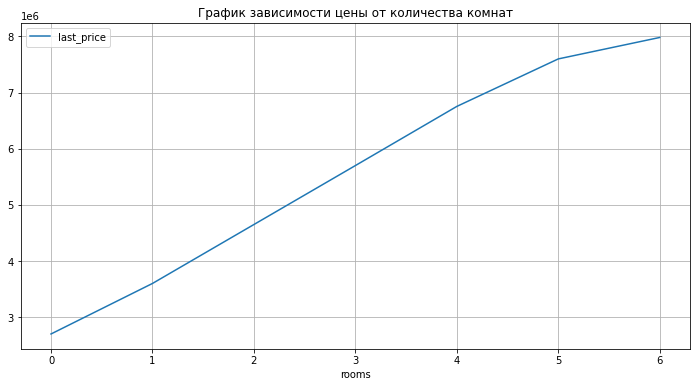

In [94]:
(
good_data
    .pivot_table(index='rooms', values='last_price', aggfunc='median') 
    .plot(title='График зависимости цены от количества комнат', grid=True, figsize=(12, 6))
);

In [95]:
good_data['rooms'].corr(good_data['last_price'])

0.4331596772726547

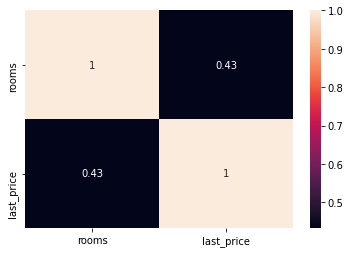

In [96]:
corr_data3 = good_data[['rooms', 'last_price']]
corrMatrix3  = corr_data3.corr()
sn.heatmap(corrMatrix3, annot=True)
plt.show()

Абсолютно точно, чем больше комнат, тем больше цена, в принципе количество комнат тесно связано с площадью, чем их больше, тем большая нужна площадь, чтобы их разместить, хотя на практике мы можем видеть трехкомнатную квартиру 60кв.м. в каком-нибудь типовом панельном доме постройки 90х и однакомнатная квартира-студия такой же площади современной постройки, индекс корреляции это подверждает, он ниже чем у пары площадь/цена.

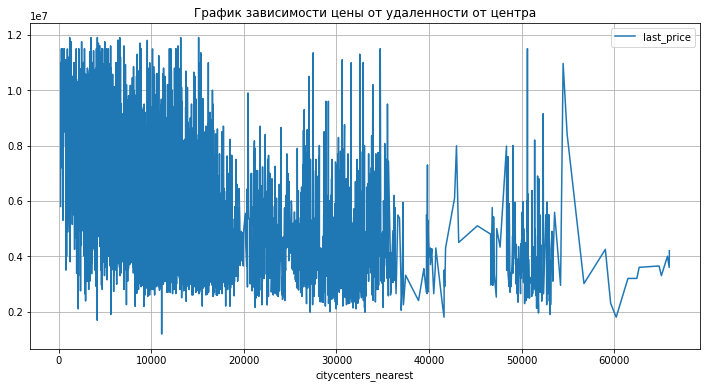

In [97]:
(
good_data
    .pivot_table(index='citycenters_nearest', values='last_price', aggfunc='median') 
    .plot(title='График зависимости цены от удаленности от центра',grid=True, figsize=(12,6))
);

In [98]:
good_data['citycenters_nearest'].corr(good_data['last_price'])

-0.22353789264790544

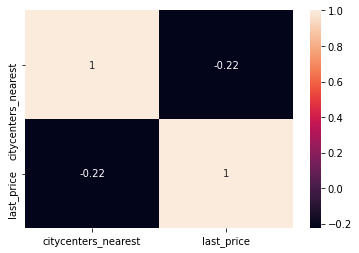

In [99]:
corr_data2 = good_data[['citycenters_nearest', 'last_price']]
corrMatrix2  = corr_data2.corr()
sn.heatmap(corrMatrix2, annot=True)
plt.show()

Зависимость стоимости квартиры от ее расположения относительно центра есть, но так же есть слишком много таких значений, при которых, например, квартира в 30км от центра стоит очень дорого, ведь она может быть очень большой и с дорогим ремонтом, поэтому удаленность от центра не сказалась критически на ее цене, индекс корреляции это подверждает, он впервые отрицательный в нашем анализе, и не очень высокий, слишком много других факторов оказывают сильное влияние на цену.

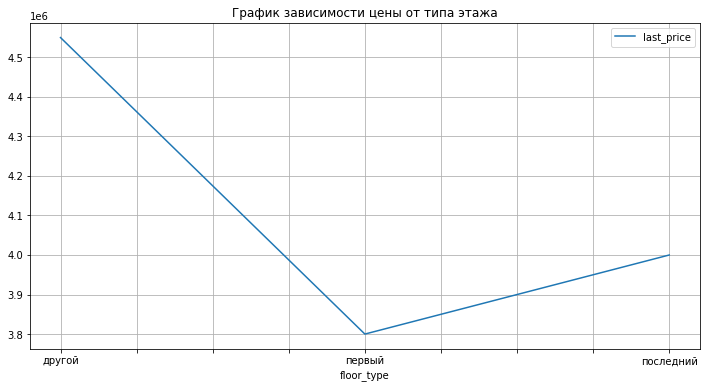

In [100]:
(
good_data
    .pivot_table(index='floor_type', values='last_price', aggfunc='median') 
    .plot(title='График зависимости цены от типа этажа',grid=True, figsize=(12,6))
);

Определенно есть зависимость от типа этажа! Больше всех не в почете первый, затем идет последний, затем все остаьные.

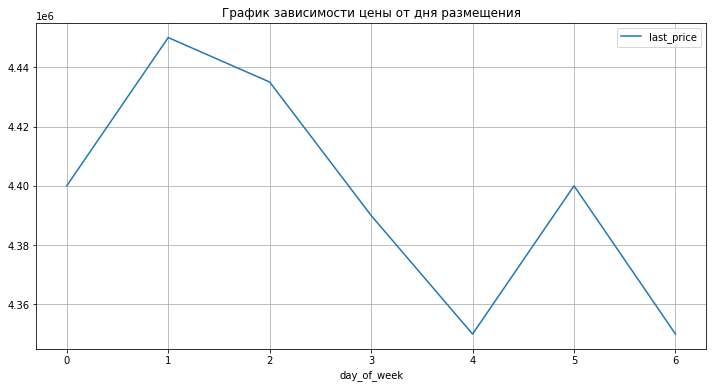

In [101]:
(
good_data
    .pivot_table(index='day_of_week', values='last_price', aggfunc='median') 
    .plot(title='График зависимости цены от дня размещения',grid=True, figsize=(12,6))
);

Вторник и среда - лидеры по цене, воскресенье - в аутсайдерах.

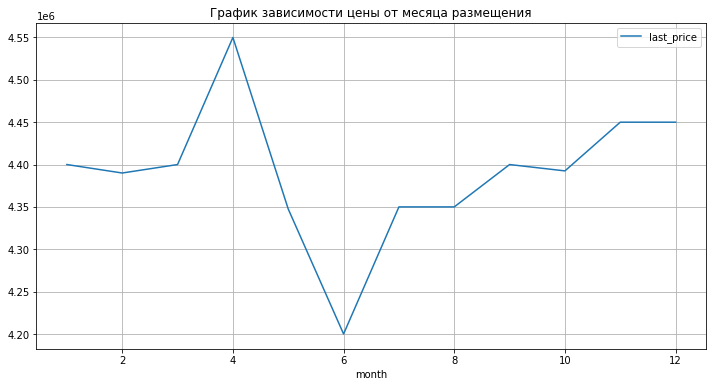

In [102]:
(
good_data
    .pivot_table(index='month', values='last_price', aggfunc='median') 
    .plot(title='График зависимости цены от месяца размещения', grid=True, figsize=(12,6))
    
);

Пик приходится на апрель, в аутсайдерах июнь.

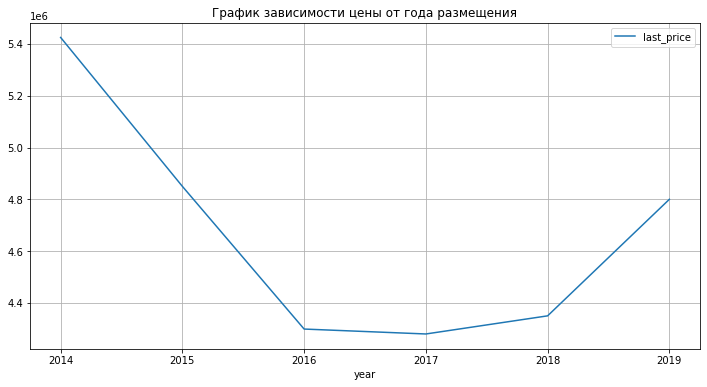

In [103]:
(
good_data
    .pivot_table(index='year', values='last_price', aggfunc='median') 
    .plot(title='График зависимости цены от года размещения',grid=True, figsize=(12,6))
);

С 2014 по 2016 был явный спад, который закончился лишь в 2018 году. с 2018 по 2019 можно отметить явный рост.

Теперь построим итоговую матрицу корреляции количественных переменных:

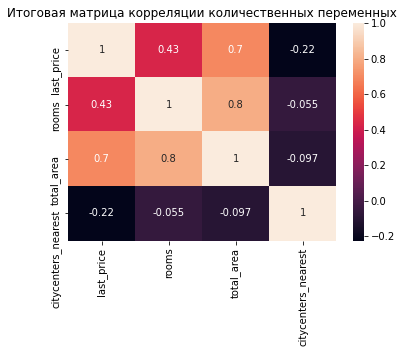

In [104]:
corr_dataa = good_data[['last_price','rooms', 'total_area', 'citycenters_nearest']]
corrMatrixx  = corr_dataa.corr()
sn.heatmap(corrMatrixx, annot=True)
plt.title("Итоговая матрица корреляции количественных переменных")
plt.show()

Выделим топ 10 населенных пунктов по количеству объявлений:

In [105]:
top10 = good_data.pivot_table(index='locality_name', values='price_m2', aggfunc=['mean','count']) 
top10.columns = top10.columns=['mean', 'count']
top10 = top10.sort_values(by='count', ascending=False).head(10)
top10['mean'] = top10['mean'].astype(int)
top10

,mean,count
locality_name,,
санкт-петербург,105736,13629
поселок мурино,85681,556
поселок шушары,78704,437
всеволожск,67221,394
пушкин,100493,337
колпино,75221,335
поселок парголово,90331,326
гатчина,68663,303
деревня кудрово,92409,298


Питер ожидаемо в авангарде!  
Теперь отсортируем по среднему значению цены за кв. метр жилья:

In [106]:
top10.sort_values(by='mean', ascending=False)

,mean,count
locality_name,,
санкт-петербург,105736,13629
пушкин,100493,337
деревня кудрово,92409,298
поселок парголово,90331,326
поселок мурино,85681,556
поселок шушары,78704,437
колпино,75221,335
гатчина,68663,303
всеволожск,67221,394


**Санкт-Петербург** - лидер по цене за "квадрат", средняя стоимость составляет **105.8 тыс.руб.**  
Дешевле всего в **Выборге**, там "квадрат" стоит **58.3 тыс. руб.**

Создадим новый столбец с расстояние до центра в км и сделаем срез датафрейма по городу Санкт-Петербург

In [107]:
s_p_flat = good_data.query('locality_name == "санкт-петербург"')
s_p_flat

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,price_m2,day_of_week,month,year,floor_type,area_ratio1,area_ratio2,citycenters_nearest_km
2,10,5196000,56.00,2015-08-20,2,2.65,5,34.3,4,False,...,574,558,92785,3,8,2015,другой,0.612500,0.148214,13
4,2,10000000,100.00,2018-06-19,2,3.03,14,32.0,13,False,...,48,121,100000,1,6,2018,другой,0.320000,0.410000,8
7,5,7915000,71.60,2019-04-18,2,2.65,24,30.0,22,False,...,502,95,110544,3,4,2019,другой,0.418994,0.263966,11
9,18,5400000,61.00,2017-02-26,3,2.65,9,43.6,7,False,...,502,289,88524,6,2,2017,другой,0.714754,0.106557,15
10,5,5050000,39.60,2017-11-16,1,2.67,12,20.3,3,False,...,553,137,127525,3,11,2017,другой,0.512626,0.214646,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23688,19,9200000,101.00,2019-04-01,3,3.05,15,63.0,12,False,...,502,23,91089,0,4,2019,другой,0.623762,0.148515,14
23689,13,3550000,35.30,2018-02-28,1,2.86,15,16.3,4,False,...,652,29,100566,2,2,2018,другой,0.461756,0.257790,16
23690,3,5500000,52.00,2018-07-19,2,2.65,5,31.0,2,False,...,502,15,105769,3,7,2018,другой,0.596154,0.115385,6
23691,11,9470000,72.90,2016-10-13,2,2.75,25,40.3,7,False,...,806,519,129903,3,10,2016,другой,0.552812,0.145405,4


Посчитаем среднюю цену за кв.м для каждого километра, построим график и определим центральную зону:

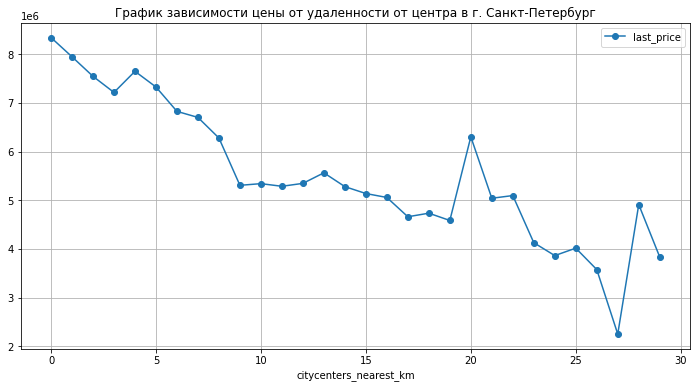

In [108]:
(
s_p_flat
    .pivot_table(index='citycenters_nearest_km', values='last_price', aggfunc='mean') 
    .plot(title='График зависимости цены от удаленности от центра в г. Санкт-Петербург',grid=True, figsize=(12,6), style='o-')
);

Стоимость квартир сильно падает после расстояния в **7 км** от центра, всё что внутри этого радиуса будем считать **центральной зоной.**

Выделим сегмент квартир в центре:

In [109]:
s_p_flat7km = s_p_flat.query('citycenters_nearest_km <=7')
s_p_flat7km

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,price_m2,day_of_week,month,year,floor_type,area_ratio1,area_ratio2,citycenters_nearest_km
24,8,6500000,97.2,2015-10-31,2,2.65,3,46.5,1,False,...,124,265,66872,5,10,2015,первый,0.478395,0.201646,2
61,18,7990000,74.0,2017-08-24,2,2.65,4,43.0,4,False,...,502,609,107972,3,8,2017,последний,0.581081,0.270270,4
94,3,3500000,29.5,2019-04-26,1,2.65,5,15.6,2,False,...,502,4,118644,4,4,2019,другой,0.528814,0.186441,7
99,32,9600000,90.0,2017-09-26,4,2.65,5,67.0,2,False,...,502,104,106666,1,9,2017,другой,0.744444,0.088889,2
111,4,4590000,40.0,2017-05-29,1,2.65,6,18.0,1,False,...,502,31,114750,0,5,2017,первый,0.450000,0.250000,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23664,5,9000000,110.0,2015-12-10,4,3.36,7,64.6,5,False,...,118,816,81818,3,12,2015,другой,0.587273,0.143636,5
23665,11,4250000,47.0,2016-05-20,1,2.65,6,18.2,1,False,...,519,131,90425,4,5,2016,первый,0.387234,0.310638,4
23681,13,5250000,43.0,2018-05-11,2,2.65,5,29.0,2,False,...,660,80,122093,4,5,2018,другой,0.674419,0.139535,7
23690,3,5500000,52.0,2018-07-19,2,2.65,5,31.0,2,False,...,502,15,105769,3,7,2018,другой,0.596154,0.115385,6


Проанализируем эту территорию и изучим следующие параметры: площадь, цена, число комнат, высота потолков. Также выделим факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления).

In [110]:
s_p_flat7km['total_area'].describe()

count    2358.000000
mean       64.112388
std        20.793742
min        12.000000
25%        47.000000
50%        62.700000
75%        79.000000
max       114.200000
Name: total_area, dtype: float64

In [111]:
s_p_flat7km['last_price'].describe()

count    2.358000e+03
mean     7.301517e+06
std      2.133091e+06
min      1.600000e+06
25%      5.700000e+06
50%      7.200000e+06
75%      8.865000e+06
max      1.190000e+07
Name: last_price, dtype: float64

In [112]:
s_p_flat7km['rooms'].value_counts()

2    898
3    690
1    524
4    206
5     22
0     16
6      2
Name: rooms, dtype: int64

In [113]:
s_p_flat7km['ceiling_height'].describe()

count    2358.000000
mean        2.865051
std         0.285110
min         2.510000
25%         2.650000
50%         2.700000
75%         3.000000
max         3.980000
Name: ceiling_height, dtype: float64

Построим графики зависимости цены от разных показателей, для наглядности еще раз продублируем графики по основному датафрейму:

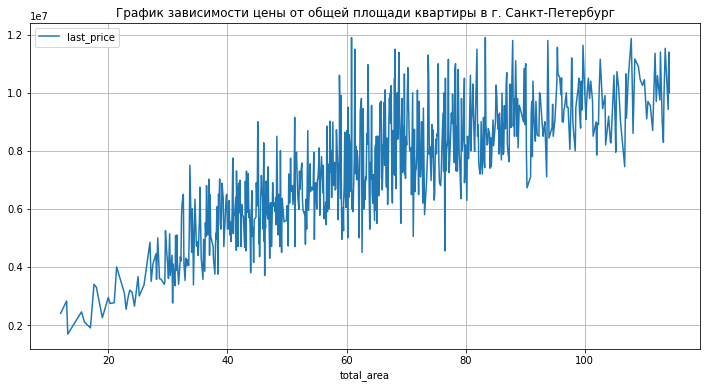

In [114]:
(
s_p_flat7km
    .pivot_table(index='total_area', values='last_price', aggfunc='median') 
    .plot(title='График зависимости цены от общей площади квартиры в г. Санкт-Петербург',grid=True, figsize=(12,6))
);

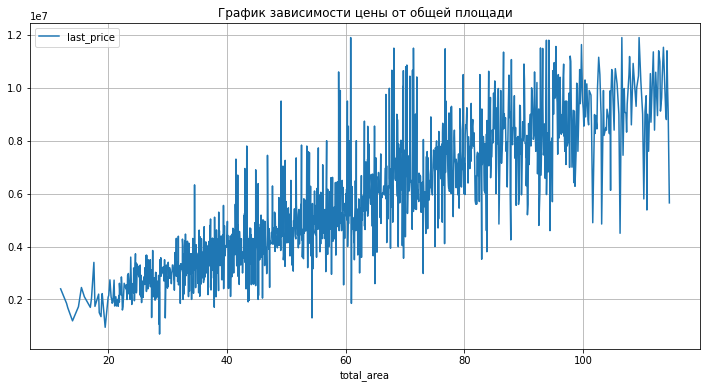

In [115]:
(
good_data
    .pivot_table(index='total_area', values='last_price', aggfunc='median') 
    .plot(title='График зависимости цены от общей площади',grid=True, figsize=(12,6))
);

In [116]:
s_p_flat7km['total_area'].corr(s_p_flat7km['last_price'])

0.7020960408949419

In [117]:
good_data['total_area'].corr(good_data['last_price'])

0.695302142067236

Графики и особенно индексы корреляции практически идентичны, общая площадь в значительной степени влияет на цену жилья.

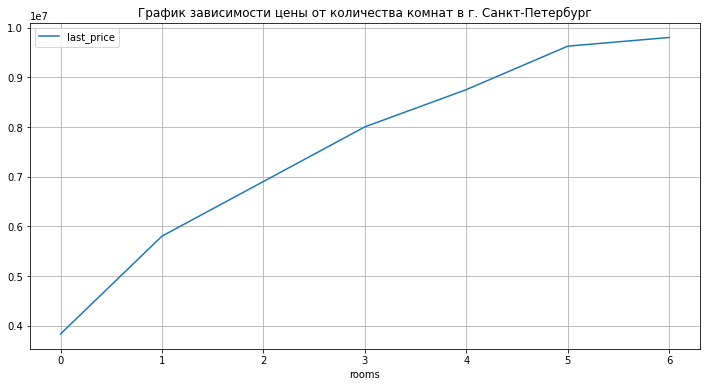

In [118]:
(
s_p_flat7km
    .pivot_table(index='rooms', values='last_price', aggfunc='median') 
    .plot(title='График зависимости цены от количества комнат в г. Санкт-Петербург',grid=True, figsize=(12,6))
);

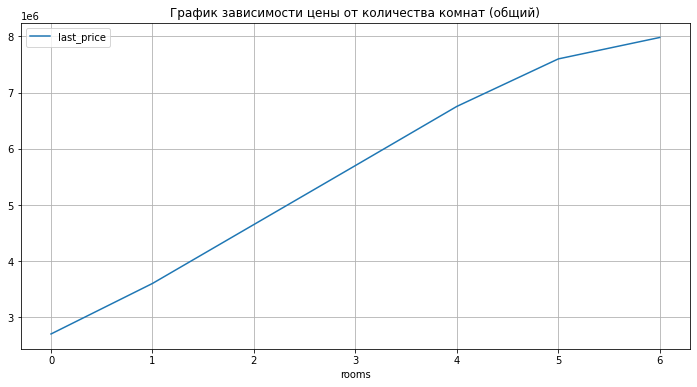

In [119]:
(
good_data
    .pivot_table(index='rooms', values='last_price', aggfunc='median') 
    .plot(title='График зависимости цены от количества комнат (общий)', grid=True, figsize=(12, 6))
);

In [120]:
s_p_flat7km['rooms'].corr(s_p_flat7km['last_price'])

0.4501810527653424

In [121]:
good_data['rooms'].corr(good_data['last_price'])

0.4331596772726547

Графики очень похожи,существует прямая зависимость цены от количества комнат, чем больше комнат, тем выше цена, индексы корреляции так же очень близки.

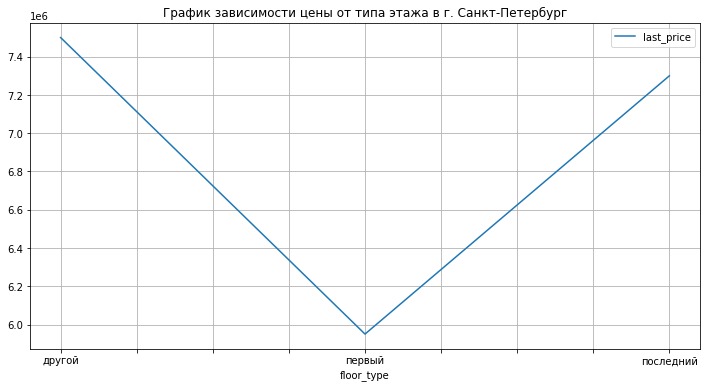

In [122]:
(
s_p_flat7km
    .pivot_table(index='floor_type', values='last_price', aggfunc='median') 
    .plot(title='График зависимости цены от типа этажа в г. Санкт-Петербург',grid=True, figsize=(12,6))
);

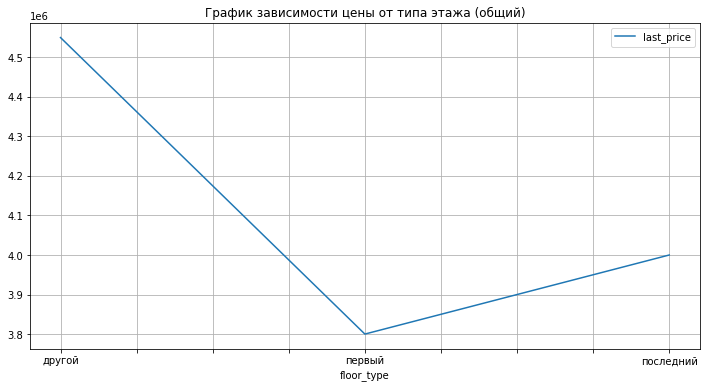

In [123]:
(
good_data
    .pivot_table(index='floor_type', values='last_price', aggfunc='median') 
    .plot(title='График зависимости цены от типа этажа (общий)',grid=True, figsize=(12,6))
);

Здесь разница более очевидна между графиками. Можно сделать вывод, что в центре последний этаж не сильно уступает остальным, скорее всего это связано с тем, что на последнем этаже самые видовые квартиры, которые ценятся. Первый и там и там наименее ценен.

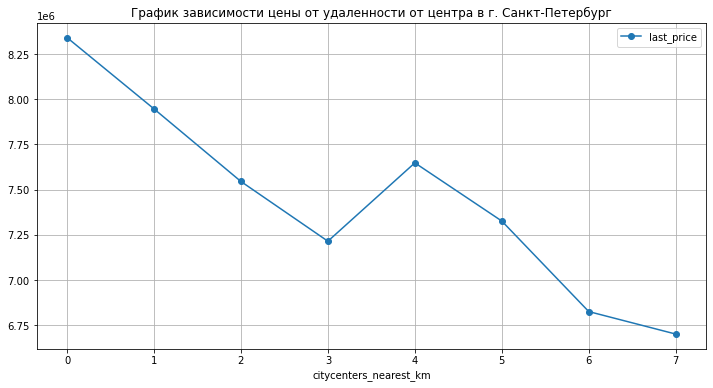

In [124]:
(
s_p_flat7km
    .pivot_table(index='citycenters_nearest_km', values='last_price', aggfunc='mean') 
    .plot(title='График зависимости цены от удаленности от центра в г. Санкт-Петербург',grid=True, figsize=(12,6), style='o-')
);

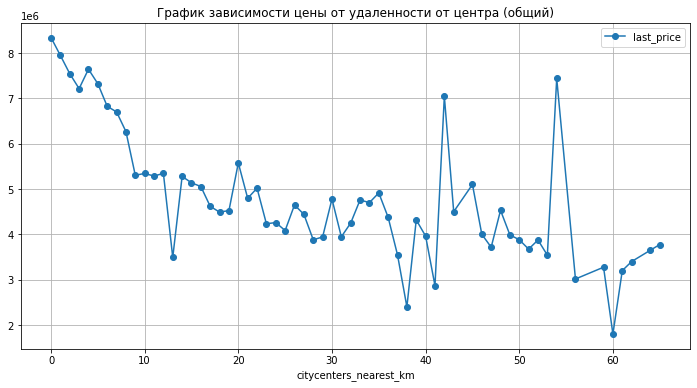

In [125]:
(
good_data
    .pivot_table(index='citycenters_nearest_km', values='last_price', aggfunc='mean') 
    .plot(title='График зависимости цены от удаленности от центра (общий)',grid=True, figsize=(12,6), style='o-')
);

In [126]:
s_p_flat7km['citycenters_nearest_km'].corr(s_p_flat7km['last_price'])

-0.1507349068723889

In [127]:
good_data['citycenters_nearest_km'].corr(good_data['last_price'])

-0.23513144086100027

На обоих графикам видна зависимость цены от удаленности от центра, чем дальше, тем дешевле, индексы корреляции разнятся не сильно, оба отрицательные, в первом значение ниже, т.к. расстояние ограничено 7 километрами.

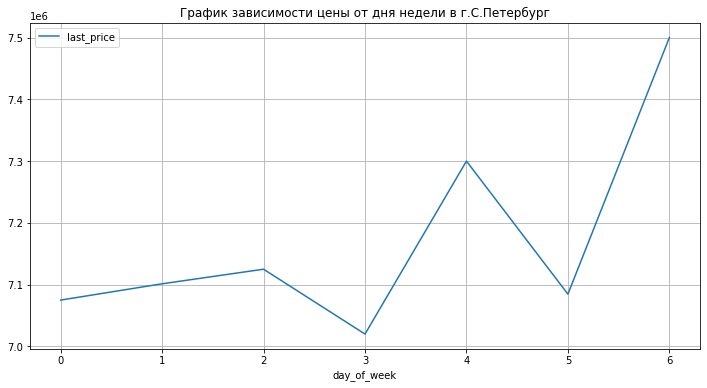

In [128]:
(
s_p_flat7km
    .pivot_table(index='day_of_week', values='last_price', aggfunc='median') 
    .plot(title='График зависимости цены от дня недели в г.С.Петербург',grid=True, figsize=(12,6))
);

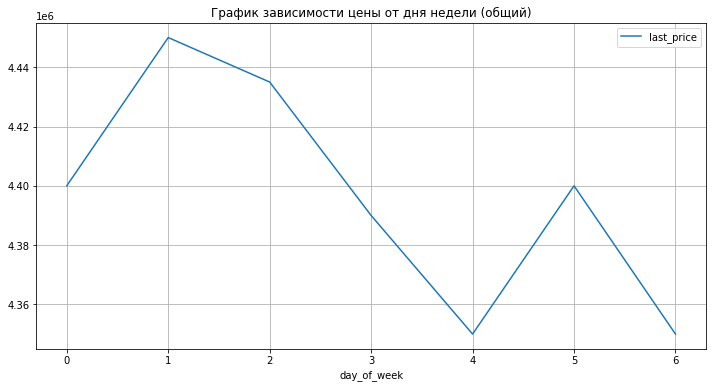

In [129]:
(
good_data
    .pivot_table(index='day_of_week', values='last_price', aggfunc='median') 
    .plot(title='График зависимости цены от дня недели (общий)',grid=True, figsize=(12,6))
);

В центре пик цены приходится на один день - воскресенье, если смотреть по всему датафрейму, то пика три - понедельник, вторник и среда.

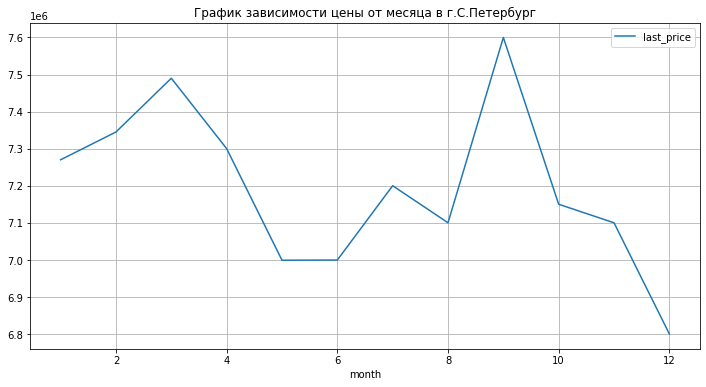

In [130]:
(
s_p_flat7km
    .pivot_table(index='month', values='last_price', aggfunc='median') 
    .plot(title='График зависимости цены от месяца в г.С.Петербург',grid=True, figsize=(12,6))
);

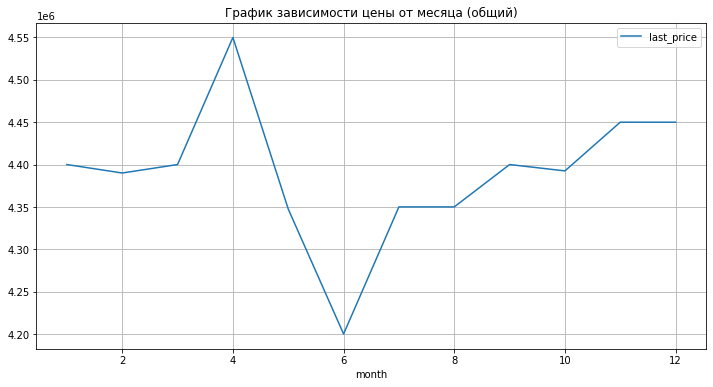

In [131]:
(
good_data
    .pivot_table(index='month', values='last_price', aggfunc='median') 
    .plot(title='График зависимости цены от месяца (общий)', grid=True, figsize=(12,6))
);

в Питере лидер - сентябрь, по всему датафрейму - апрель

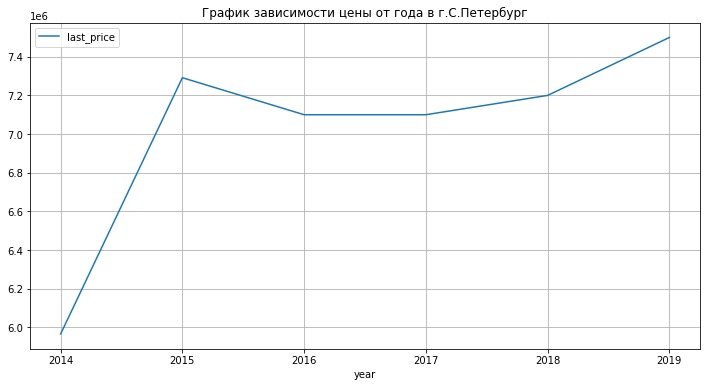

In [132]:
(
s_p_flat7km
    .pivot_table(index='year', values='last_price', aggfunc='median') 
    .plot(title='График зависимости цены от года в г.С.Петербург',grid=True, figsize=(12,6))
);

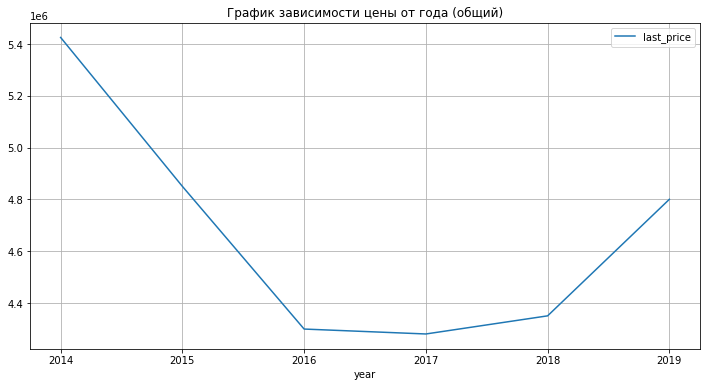

In [133]:
(
good_data
    .pivot_table(index='year', values= 'last_price', aggfunc='median') 
    .plot(title='График зависимости цены от года (общий)',grid=True, figsize=(12,6))
);

По годам графики сильно отличаются, если жилье в центре Питера неуклонно росло в цене, начиная с 2015 года, то остальное жилье подешевело к 2015 году и рост наметился лишь в 2018.

Построим итоговую матрицу корреляции по г. Санкт-Петербург и для наглядности продублируем матрицу по всему датафрейму:

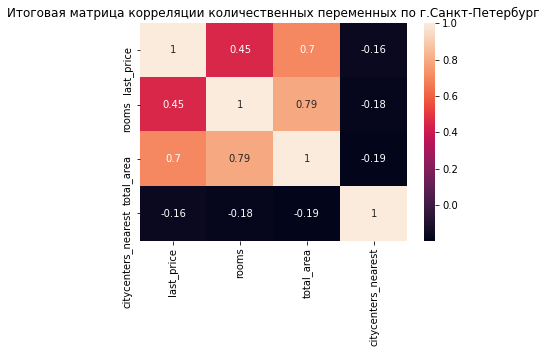

In [134]:
corr_data_final = s_p_flat7km[['last_price','rooms', 'total_area', 'citycenters_nearest']]
corrMatrix_f  = corr_data_final.corr()
sn.heatmap(corrMatrix_f, annot=True)
plt.title("Итоговая матрица корреляции количественных переменных по г.Санкт-Петербург")
plt.show()

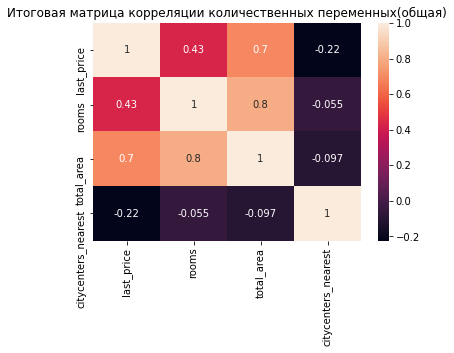

In [135]:
corr_dataa = good_data[['last_price','rooms', 'total_area', 'citycenters_nearest']]
corrMatrixx  = corr_dataa.corr()
sn.heatmap(corrMatrixx, annot=True)
plt.title("Итоговая матрица корреляции количественных переменных(общая)")
plt.show()

Индексы корреляции для числовых переменных получились практически идентичными в 2 датафреймах, самая большая разница у показателя удаленности от центра, это можно объяснить тем, что датафрейм с квартирами в центре Питера ограничен макс. удаленностью квартир от центра в 7 км.

## Общий вывод

Подводя итоги, можно сделать вывод, что на конечную стоимость квартиры влияют многие факторы, выделим основные: площадь квартиры, этаж, удаленность квартиры от центра города и, конечно, сам населенный пункт, так квартиры в Санкт-Петербурге ожидаемо оказались самыми дорогими.
Мы так же выяснили, что центром города является радиус в 7км, квартиры в нем самые дорогие, а еще в центре Питера ценится последний этаж, в отличии от остальных локаций, все дело в том, что такие квартиры "видовые".

Итоговые параметры для определения рыночной стоимости квартиры будут выглядить следующим образом:
* общая площадь квартиры (не более 114,5 кв. м.)
* расстояние до центра города (центр города огранчен окружностью радиусом 7 км)
* число комнат и этаж квартиры (количество комнат - не более 6; чем ближе к центру, тем эти факторы весомее)
* срок продажи квартиры (слишком быстрая продажа — до 1.5 месяцев (обенно аномальные сроки меньше 2-х недель), слишком долгая продажа — более 14 месяцев (430 дней).
* кроме того, необходимо ввести ограничения на ввод данных о высоте потолков: допущено множество  ошибок (27 м вместо 2,7 м, потолки менее 2 м. и выше 4 м. и т.д.).
